In [1]:
import os
os.chdir("..")
import relegy.embeddings as rle
import relegy.metrics as rlm
os.chdir("Analysis")

In [18]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import inspect
from IPython.display import clear_output
from matplotlib.pylab import rcParams
import sys

In [3]:
def get_embedding_methods_iterable():
    return filter(lambda x: x[0][:2] != "__", inspect.getmembers(sys.modules['relegy.embeddings']))

In [4]:
def generate_clusters_graph(n, k, p):
    partition = np.random.multinomial(n, np.ones(k)/k, size=1)[0]
    labels = np.repeat(np.arange(k), partition)
    G = nx.Graph()
    cur_min = 0
    for i in partition:
        ng = nx.complete_graph(range(cur_min, cur_min+i))
        G.add_nodes_from(ng)
        G.add_edges_from(ng.edges)
        cur_min += i
#     perm = np.random.permutation(G.nodes)
#     labs = dict(enumerate(perm))
#     G = nx.relabel_nodes(G, labs)
    G1 = nx.complement(G)
    arr = np.arange(len(G1.edges))
    new_edges_size = np.floor(p*len(arr))
    new_edges = np.random.choice(arr, size=new_edges_size.astype(int))
    G.add_edges_from(np.array(G1.edges)[new_edges,:])
    return G, labels

In [5]:
G, labels = generate_clusters_graph(100, 7, 0.03)

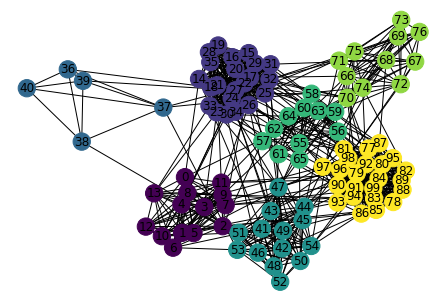

In [6]:
nx.draw(G, with_labels=True, node_color=labels)

# LaplacianEigenmaps fast_embed

In [7]:
Z_le = rle.LaplacianEigenmaps.fast_embed(G, num_iter=300, d=5)

Iteration limit reached    (Exit mode 9)
            Current function value: [0.01155279]
            Iterations: 300
            Function evaluations: 2512
            Gradient evaluations: 300


In [8]:
Z_scaled = StandardScaler().fit_transform(Z_le)
Z_le_pca = PCA(n_components=2).fit_transform(Z_scaled)

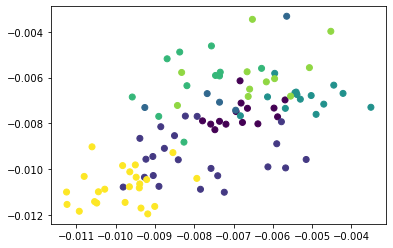

In [9]:
plt.scatter(Z_le[:, 0], Z_le[:, 1], c=labels)

# GraphFactorization

In [10]:
gf = rle.GraphFactorization(G)

gf.initialize(d = 2)
gf.initialize_model(lr=0.01)
gf.fit(num_iter = 300)
Z_gf = gf.embed()

Epoch 1: 907.6379
Epoch 2: 903.57025
Epoch 3: 897.811
Epoch 4: 890.1874
Epoch 5: 880.6031
Epoch 6: 868.99005
Epoch 7: 855.29175
Epoch 8: 839.45795
Epoch 9: 821.4456
Epoch 10: 801.2194
Epoch 11: 778.75214
Epoch 12: 754.02625
Epoch 13: 727.03815
Epoch 14: 697.8051
Epoch 15: 666.3753
Epoch 16: 632.8377
Epoch 17: 597.3308
Epoch 18: 560.0466
Epoch 19: 521.23236
Epoch 20: 481.1912
Epoch 21: 440.2817
Epoch 22: 398.91727
Epoch 23: 357.5638
Epoch 24: 316.7357
Epoch 25: 276.98856
Epoch 26: 238.90816
Epoch 27: 203.09492
Epoch 28: 170.14137
Epoch 29: 140.60265
Epoch 30: 114.95948
Epoch 31: 93.5746
Epoch 32: 76.64618
Epoch 33: 64.165054
Epoch 34: 55.884907
Epoch 35: 51.31548
Epoch 36: 49.74691
Epoch 37: 50.30826
Epoch 38: 52.055225
Epoch 39: 54.07382
Epoch 40: 55.580784
Epoch 41: 56.001015
Epoch 42: 55.008213
Epoch 43: 52.525166
Epoch 44: 48.689598
Epoch 45: 43.79745
Epoch 46: 38.23703
Epoch 47: 32.425343
Epoch 48: 26.754618
Epoch 49: 21.553118
Epoch 50: 17.061565
Epoch 51: 13.424164
Epoch 52: 10.6

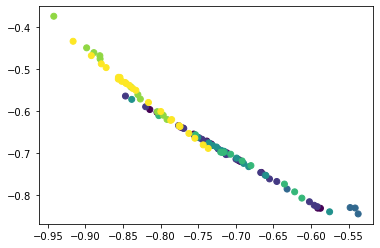

In [11]:
plt.scatter(Z_gf[:, 0], Z_gf[:, 1], c=labels)

In [12]:
obtained_matrix = Z_gf @ Z_gf.T

In [13]:
rmse = rlm.rmse(nx.to_numpy_array(G, nodelist=G.nodes), obtained_matrix)

patk = rlm.precision_at_k(nx.to_numpy_array(G, nodelist=G.nodes), obtained_matrix)

In [14]:
print(rmse)

0.8911530463374944


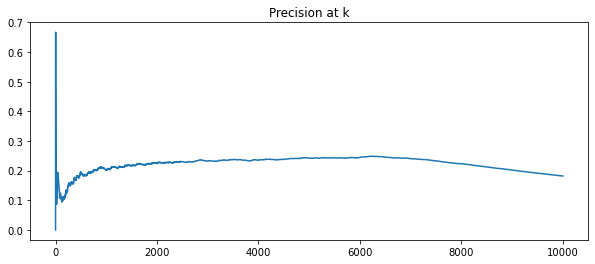

In [15]:
rcParams["figure.figsize"] = 10, 4
plt.plot(patk)
plt.title("Precision at k")
plt.show()

In [16]:
gf.fit(10)

Epoch 1: 5.1050253
Epoch 2: 5.1044765
Epoch 3: 5.1039305
Epoch 4: 5.103387
Epoch 5: 5.1028485
Epoch 6: 5.102313
Epoch 7: 5.10178
Epoch 8: 5.101252
Epoch 9: 5.1007257
Epoch 10: 5.1002045


In [19]:
results_dictionary = {}
for name, class_handle in get_embedding_methods_iterable():
    if not (name == "GCN" or name == "GNN"):
        print("Currently processing " + str(name))
        results_dictionary[name] = class_handle.fast_embed(G, d=2)
        clear_output()

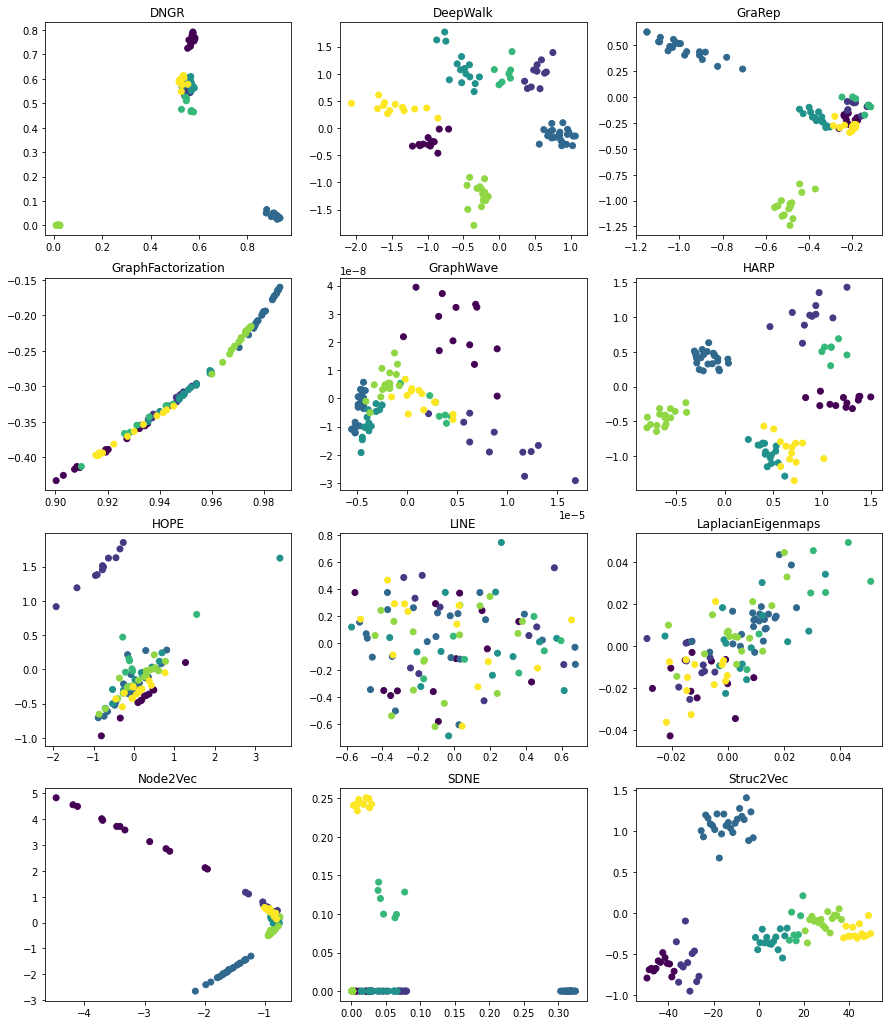

In [277]:
rcParams["figure.figsize"] = 15, 18
fig, axs = plt.subplots(4, 3)
names = list(results_dictionary.keys())
for i in range(len(names)):
    ix_x = i // 3
    ix_y = i % 3
    cur_Z = results_dictionary[names[i]]
    if cur_Z.shape[1] != 2:
        ss = StandardScaler().fit_transform(cur_Z)
        pca_Z = PCA(n_components=2).fit_transform(cur_Z)
        cur_Z = pca_Z
    axs[ix_x, ix_y].scatter(cur_Z[:, 0], cur_Z[:, 1], c=labels)
    axs[ix_x, ix_y].set_title(names[i])

In [278]:
results_dictionary = {}
for name, class_handle in get_embedding_methods_iterable():
    if not (name == "GCN" or name == "GNN"):
        print("Currently processing " + str(name))
        results_dictionary[name] = class_handle.fast_embed(G, d=5)
        clear_output()

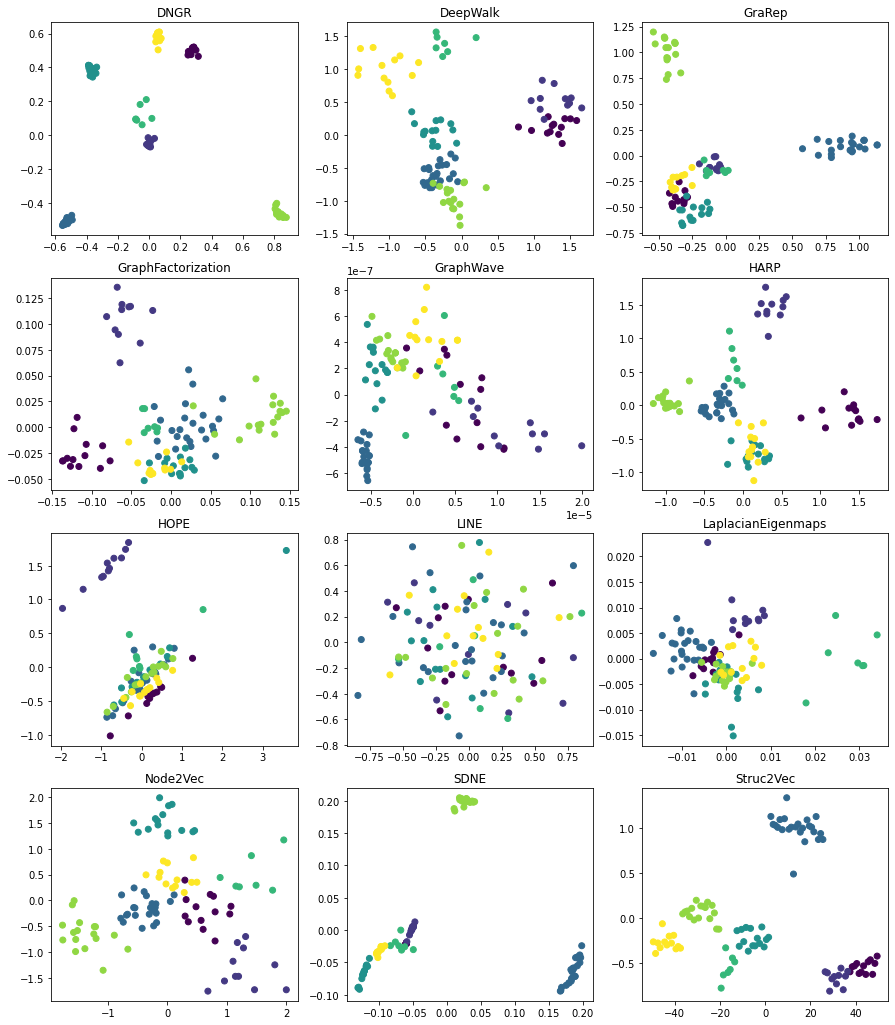

In [279]:
rcParams["figure.figsize"] = 15, 18
fig, axs = plt.subplots(4, 3)
names = list(results_dictionary.keys())
for i in range(len(names)):
    ix_x = i // 3
    ix_y = i % 3
    cur_Z = results_dictionary[names[i]]
    if cur_Z.shape[1] != 2:
        ss = StandardScaler().fit_transform(cur_Z)
        pca_Z = PCA(n_components=2).fit_transform(cur_Z)
        cur_Z = pca_Z
    axs[ix_x, ix_y].scatter(cur_Z[:, 0], cur_Z[:, 1], c=labels)
    axs[ix_x, ix_y].set_title(names[i])

In [4]:
#GNN
gnn = rle.GNN(G)

NameError: name 'G' is not defined